I remember first time learning regression and remember the bullet points of assumptions. I believe people still learn that way, knowing that *multicollinearity is an issue*. But, what exactly is the issue? If you are following my posts on the [basketball analytics newsletter](https://thereadstep.substack.com/), adjusted plus-minus (APM) models are actually up against same issue.

Anyway, let's get into it with an example. Btw, I'm going to using a Bayesian regression on this one since I feel like it makes the example more intuitive. However, feel free to give it a go with the frequentist way, which you'll end up noticing similar things.

In [2]:
df = pd.read_csv('possum.csv', usecols=['skull_w', 'head_l'])
df.head()

,head_l,skull_w
0,94.1,60.4
1,92.5,57.6
2,94.0,60.0
3,93.2,57.1
4,91.5,56.3


You probably remember the possum data from other posts. Let's predict `head_l` from `skull_w`. But I'll do something extreme, I'll add exact copy of `skull_w` and put both the original and the copy into the model.

But before, here's what it looks like with a simple linear regression (the frequentist way).

In [3]:
model = smf.ols('head_l ~ skull_w', data=df)
res = model.fit()

res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,46.1954,4.554,10.145,0.000,37.163,55.227
skull_w,0.8158,0.080,10.207,0.000,0.657,0.974


0.816 — keep that in mind.

In [4]:
df['skull_w_copy'] = df['skull_w']

df.head()

,head_l,skull_w,skull_w_copy
0,94.1,60.4,60.4
1,92.5,57.6,57.6
2,94.0,60.0,60.0
3,93.2,57.1,57.1
4,91.5,56.3,56.3


In [16]:
with pm.Model() as model1:

    cept = pm.Normal('intercept', 92.6, 1)

    # I don't mess with the symmetry
    beta_skullw = pm.Normal('skull_w', 0, 3)
    beta_skullw_copy = pm.Normal('skull_w_copy', 0, 3)

    # Sigma has to be positive
    sigma = pm.HalfNormal('sigma', 6)

    # Estimation
    mu = cept + (skull_w_centered*beta_skullw) + (skull_w_centered_copy*beta_skullw_copy)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['head_l'])

    pm.Deterministic('beta_sum', beta_skullw + beta_skullw_copy) # This is actually what's identifiable.

    trace = pm.sample(1000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, skull_w, skull_w_copy, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 9 seconds.


array([<Axes: title={'center': 'skull_w'}>,
       <Axes: title={'center': 'skull_w_copy'}>,
       <Axes: title={'center': 'beta_sum'}>], dtype=object)

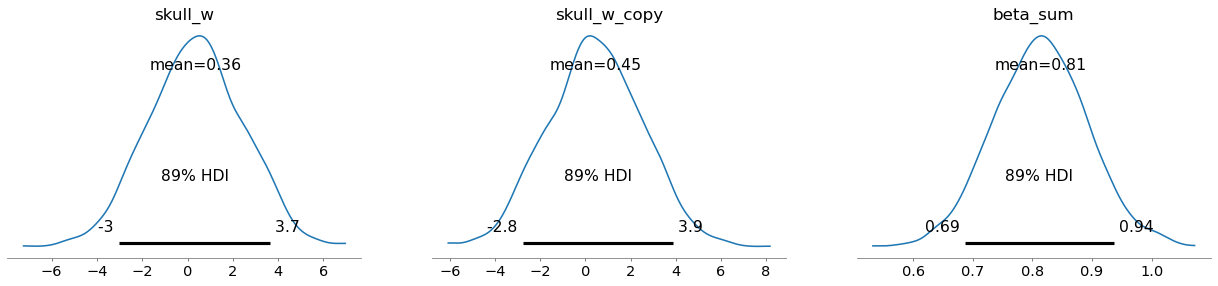

In [17]:
az.plot_posterior(trace, var_names=['skull_w', 'skull_w_copy', 'beta_sum'], hdi_prob=.89)

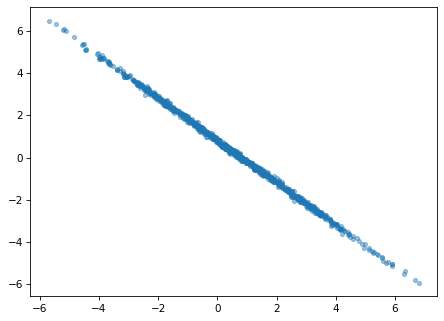

In [19]:
skull_w_dist = trace.posterior['skull_w'][1]
skull_w_copy_dist = trace.posterior['skull_w_copy'][1]

plt.figure(figsize=(7, 5))

plt.scatter(skull_w_dist, skull_w_copy_dist, s=15, alpha=.43)

In [20]:
for i in range(10):
    print((float(skull_w_dist[i]), float(skull_w_copy_dist[i])))

(2.1719939977885847, -1.26952688557421)
(0.4554015427374477, 0.2744283320413641)
(1.4619682228648934, -0.6567439452181076)
(1.744581113218752, -0.85540185790859)
(-1.054535017664959, 1.987257401399897)
(1.5541538977650355, -0.7291865925845055)
(0.2624248774653002, 0.6081965328591851)
(1.357268352948161, -0.46139537255610363)
(1.9091333381189857, -0.8864721497806237)
(-1.9855787873259831, 2.8171167716562304)


Okay, the things that get attention on the first row of plots:

- The posterior distributions are extremely wide for both betas, reflecting the uncertainty.
- Could you calculate the sum of their means? :)
- Looking at the distribution of `beta_sum`: It's centered around 0.81 with not so wide range. It's because _only_ the *sum* is identifiable.

_Unidentifiability_ means that the model does not make it possible to estimate the value of the parameter. Multicollinearity falls into this bucket of problems.

The second plot is showing actually what's going on. _After knowing the value of one, what's the value of the other?_ Well, both variables carry the same information. Hence, as you know one the other doesn't help much — ridge of equally plausible joint values.

$\displaystyle y = \beta_{0} + \beta_{1}X_1 + \beta_{2}X_2$

Those variables are the same in our example, so let's denote both as X.

$\displaystyle y = \beta_{0} + \beta_{1}X + \beta_{2}X$

Which leads to:

$\displaystyle y = \beta_{0} + (\beta_{1}+\beta_{2})X$

Hence, they are not separable. The effect on y is their sum.

Alright, so, _is the model wrong?_

Nope. Predictions will be just fine, if that's what you care about. You just can't separate the effect of either variable, so you can't make up your mind about which one is more important.

I hope this post helps with internalizing what the issue is with multicollinearity. I'll keep up with stats posts in the future. Until then, take care. 